In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.3 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import (
    FuncAnimation,
)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Constantes e Parâmetros da Rede

In [3]:
SAMPLE_POINTS = 2000
T_START = 0
T_END = WIDTH = LENGTH = 1.0
ALPHA = 2
ARCHITECTURE = (
    [3] + [60] * 5 + [1]
)
ACTIVATION = "tanh"
INITIALIZER = "Glorot uniform"
LEARNING_RATE = 1e-3
LOSS_WEIGHTS = [
    10,
    1,
    1,
    1,
    1,
    10,
]  # Pesos dos componentes da função de perda
ITERATIONS = 10000  # Número de épocas
OPTIMIZER = "adam"  # Otimizador
BATCH_SIZE = 32

# Equação Diferencial

In [4]:
def pde(X, T):
    # Calculate second derivatives (Hessians) of T with respect to X in both dimensions
    dT_xx = dde.grad.hessian(T, X, i=0, j=0)
    dT_yy = dde.grad.hessian(T, X, i=1, j=1)

    # Calculate first derivative (Jacobian) of T with respect to X in time dimension
    dT_t = dde.grad.jacobian(T, X, j=2)

    # Return the defined PDE
    return dT_t - ALPHA * (dT_xx + dT_yy)

# Condições de Contorno

In [5]:
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)

# Condição inicial

In [6]:
# Define initial condition
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)

# Inicializa com o campo de temperaturas sendo zero
def init_func(X):
    t = np.zeros((len(X), 1))
    return t

In [7]:
def constraint_top(X):
    return np.ones((len(X), 1)) * 100 # No contorno do topo temperatura é sempre 100

def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )

# Definindo geometrias

In [8]:
# Define geometry and time domains
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])  # Geometria
timedomain = dde.geometry.TimeDomain(0, T_END)  # Tempo
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [9]:
# Condição de contorno e condição inicial
bc_l = dde.NeumannBC(geomtime, func_zero, boundary_left)
bc_r = dde.DirichletBC(geomtime, func_zero, boundary_right)
bc_up = dde.NeumannBC(geomtime, constraint_top, boundary_top)
bc_low = dde.NeumannBC(geomtime, func_zero, boundary_bottom)
ic = dde.IC(geomtime, init_func, boundary_initial)

In [11]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_up, bc_low, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
)

# Rede e treinamento

In [12]:
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)
net.apply_output_transform(lambda _, y: abs(y))
model = dde.Model(data, net)

In [13]:
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
# Train the model
losshistory, trainstate = model.train(
    iterations=ITERATIONS,
    batch_size=BATCH_SIZE,
)

Compiling model...
Building feed-forward neural network...
'build' took 0.096360 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.267711 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.51e+00, 1.27e-02, 4.38e-02, 9.99e+03, 1.09e-02, 1.16e-01]    [1.51e+00, 1.27e-02, 4.38e-02, 9.99e+03, 1.09e-02, 1.16e-01]    []  
1000      [3.01e+03, 2.33e+01, 1.66e+02, 2.48e+03, 1.22e+01, 6.33e+02]    [3.01e+03, 2.33e+01, 1.66e+02, 2.48e+03, 1.22e+01, 6.33e+02]    []  
2000      [4.93e+02, 7.19e+01, 1.15e+02, 8.67e+02, 1.24e+01, 6.57e+02]    [4.93e+02, 7.19e+01, 1.15e+02, 8.67e+02, 1.24e+01, 6.57e+02]    []  
3000      [2.83e+02, 1.24e+02, 8.58e+01, 7.46e+02, 1.09e+01, 5.14e+02]    [2.83e+02, 1.24e+02, 8.58e+01, 7.46e+02, 1.09e+01, 5.14e+02]    []  
4000      [1.77e+02, 1.51e+02, 7.22e+01, 6.33e+02, 9.49e+00, 4.08e+02]    [1.77e+02, 1.51e+02, 7.22e+01, 6.33e+02, 9.49e+00, 4.08e+02]    []  
5000      [9.00e+01, 1.41e+02, 6.25e+01, 5.86e+02, 1.21e+01, 3.48e+02]    [9.00e+01, 1.41

In [14]:
X = geomtime.random_points(1000)
err = 1
while err > 0.01:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))
    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    # Stop training if the model isn't learning anymore
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
    model.train(
        iterations=100, disregard_previous_best=True, batch_size=BATCH_SIZE, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    dde.optimizers.set_LBFGS_options(
        maxcor=100,
    )
    losshistory, train_state = model.train(batch_size=BATCH_SIZE,)

Mean residual: 2.709e+00
Adding new point: [0.6945725  0.96414256 0.42614767] 

Compiling model...
'compile' took 0.762380 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [2.13e+02, 1.66e+02, 5.57e+01, 6.81e+02, 6.10e+01, 1.48e+02]    [2.10e+02, 1.66e+02, 5.57e+01, 6.81e+02, 6.10e+01, 1.48e+02]    []  
10100     [1.59e+02, 1.29e+02, 1.69e+01, 4.07e+03, 3.52e+01, 4.97e+01]    [1.59e+02, 1.29e+02, 1.69e+01, 4.07e+03, 3.52e+01, 4.97e+01]    []  

Best model at step 10000:
  train loss: 1.32e+03
  test loss: 1.32e+03
  test metric: []

'train' took 3.347021 s

Compiling model...
'compile' took 0.495943 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10100     [1.59e+01, 1.29e+02, 1.69e+01, 4.07e+03, 3.52e+01, 4.97e+00]    [1.59e+01, 1.2

KeyboardInterrupt: 

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


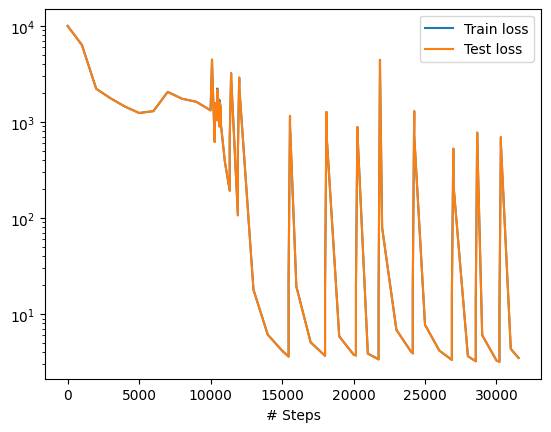

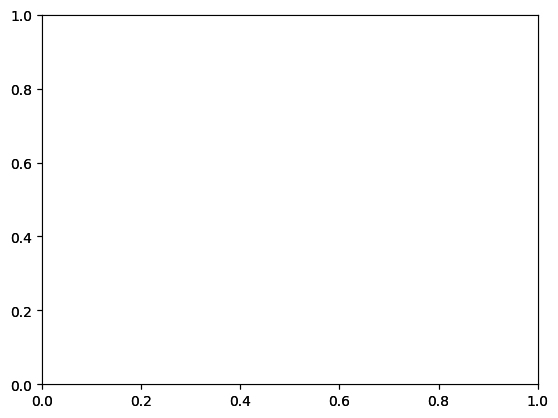

In [15]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
plt.show()
plt.savefig("loss_history_plot_Heat2d")
plt.close()

# Predict the solution at different time points and create an animation
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

# Set up the grid
nelx = 100  # Number of elements in x direction
nely = 100  # Number of elements in y direction
timesteps = 101  # Number of time steps
x = np.linspace(0, 1, nelx + 1)  # x coordinates
y = np.linspace(0, 1, nely + 1)  # y coordinates
t = np.linspace(0, 1, timesteps)  # Time points

# Prepare the data for the prediction
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

# Predict Solution and Residual
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)  # Scale and reshape solution
residual = model.predict(test_domain, operator=pde)
residual = residual.reshape(test_x.shape)  # Reshape residuals


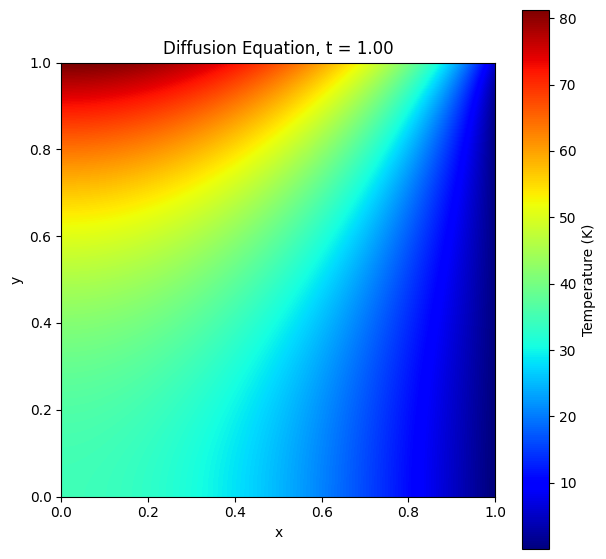

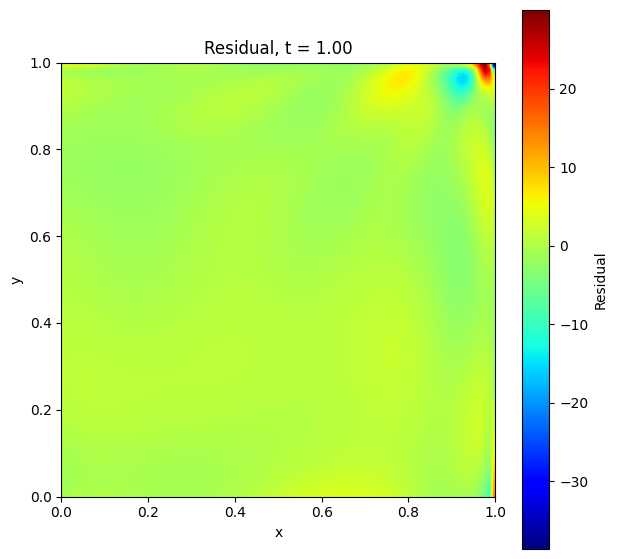

In [16]:
# Animation function
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Create initial image and colorbar
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, 1, 0, 1],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Update function for the frames
    def updatefig(k):
        # Update image data
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Update the color limits

        # Update colorbar
        cb.update_normal(im)

        # Update title
        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


# Create and save the solution animation
animate_solution(
    predicted_solution,
    f"pinn_heat2d_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation",
    "Temperature (K)",
    t,
)

# Create and save the residuals animation
animate_solution(
    residual,
    f"pinn_heat2d_residual_{str(ALPHA)}.mp4",
    "Residual",
    "Residual",
    t,
)